In [6]:
import pydicom as dicom
import cv2   
import glob
from tqdm import tqdm
from torchvision import transforms, utils
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from itertools import islice 

In [7]:
# specify your image path
images_path = '../../../../datasets/femurDCMs/*/*'

for impath in tqdm(glob.glob(images_path)):
    ds = dicom.dcmread(impath)
    pixel_array_numpy = ds.pixel_array
    image_format = '.png' # or '.jpg'
    impath = impath.replace('.DCM', image_format)
    cv2.imwrite(impath, pixel_array_numpy)
print('done')

0it [00:00, ?it/s]

done


In [9]:
# specify your image path
images_path = '../../../../datasets/femurDCMs/*/*.DCM'

imlist = []
for i,impath in tqdm(enumerate(glob.glob(images_path))):
    imlist.append((dicom.dcmread(impath).pixel_array,int(impath[54:-4]),impath[34:]))
    if i>=100:
        break
#     image_format = '.png' # or '.jpg'
#     impath = impath.replace('.DCM', image_format)
#     cv2.imwrite(impath, pixel_array_numpy)
imlist = iter(imlist)
print('done')

100it [00:09, 10.31it/s]

done


5562054437
7979
-2603
10582


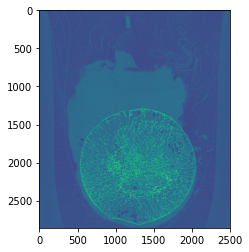

In [41]:
img = next(imlist)[0]
plt.imshow(img)
print(np.sum(np.sum(img)))
print(np.max(img))
print(np.min(img))
print(np.max(img)-np.min(img))

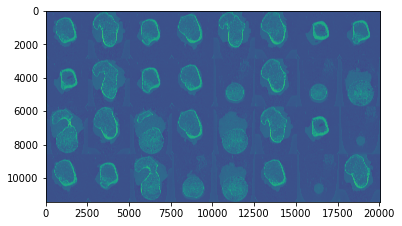

In [123]:
plt.imshow(np.concatenate([np.concatenate([im[0] for im in islice(imlist,8)],axis=1) 
                           for i in range(4)],axis=0))